# Algorithmic Game Theory

Students:

- **Emanuele Conforti (252122)**
- **Jacopo Garofalo (252093)**
- **Gianmarco La Marca (252256)**

## **Assignment**

Consider a setting with a set N={1,2,…,n} of agents and with a set S = {s_1,...,s_m} of skills. Each agent i ∈ N is associated with a set of skills denoted by S_i ⊆ S. Note that there is no a-priori specified number of skills that each agent owns; for instance, an agent might have just one skill, while another might have all the available skills. In fact, there is a task t to be completed and all the skills in S are required to this end. Hence, agents are required to collaborate with each other and a number of strategic issues come into play.

For each of the following questions, implement in Python a method that can provide results for any possible pair N,S. Report then the results obtained over the instance, with 4 agents and 3 skills, graphically depicted below according to an intuitive notation (an edge means that the agent owns the corresponding skill).

In [1]:
agents = frozenset(['1', '2', '3', '4'])

skills = frozenset(['s1', 's2', 's3'])

skills_map = {
    '1': ['s1'],
    '2': ['s1', 's2'],
    '3': ['s1', 's2'],
    '4': ['s3'],
}

reward = 100

# v = {
#     frozenset(['1']): 0,
#     frozenset(['2']): 0,
#     frozenset(['3']): 0,
#     frozenset(['4']): 0,
#     frozenset(['1', '2']): 0,
#     frozenset(['1', '3']): 0,
#     frozenset(['1', '4']): 0,
#     frozenset(['2', '3']): 0,
#     frozenset(['2', '4']): 100,
#     frozenset(['3', '4']): 100,
#     frozenset(['1', '2', '3']): 0,
#     frozenset(['1', '2', '4']): 100,
#     frozenset(['1', '3', '4']): 100,
#     frozenset(['2', '3', '4']): 100,
#     frozenset(['1', '2', '3', '4']): 100,
# }

In [2]:
from itertools import combinations

# A function to generate the powerset: it returns a list of 2^(n-1) frozen sets
def powerset(List):
    subs = [frozenset(j) for i in range(len(List)) for j in combinations(List, i+1)]
    subs.append(frozenset()) # WE NEED TO INCLUDE ALSO THE EMPTY SET
    return subs

In [3]:
# Used to calculate the characteristic function from a set of agents, a set of skills, a reward and a mapping agents -> skills
def calculate_characteristic_function(agents, skills, agents_skills_map, reward):
    characteristic_func = {}

    for c in powerset(agents):
        characteristic_func[c] = 0
        covered_skills = set()
        for agent in c:
            covered_skills.update(agents_skills_map[agent])
        if len(covered_skills) == len(skills):
            characteristic_func[c] = reward
    return characteristic_func

In [4]:
v = calculate_characteristic_function(agents, skills, skills_map, reward)
print('\n'.join(f'{k}: {v[k]}' for k in v))

frozenset({'4'}): 0
frozenset({'3'}): 0
frozenset({'1'}): 0
frozenset({'2'}): 0
frozenset({'4', '3'}): 100
frozenset({'4', '1'}): 0
frozenset({'4', '2'}): 100
frozenset({'3', '1'}): 0
frozenset({'3', '2'}): 0
frozenset({'1', '2'}): 0
frozenset({'4', '3', '1'}): 100
frozenset({'4', '3', '2'}): 100
frozenset({'4', '1', '2'}): 100
frozenset({'3', '1', '2'}): 0
frozenset({'4', '3', '1', '2'}): 100
frozenset(): 0


In [5]:
v[frozenset(['2', '4'])]

100

## **Task 1**

Assume that completing the task t leads to a reward of 100$. Then, compute the Shapley value associated with the agents as a fair way to distribute that reward among them. And, finally, check whether the Shapley value is in the core of the coalitional game induced by the setting.

### **Shapley value**

In [6]:
def is_superadditive(characteristic_function, p):
    power_set = powerset(p)
    superadditive = True

    for i in power_set:
        for j in power_set:
            # check that the two coalitions i and j are disjoint
            if len(i.intersection(j)) == 0:
                sum = characteristic_function[i] + characteristic_function[j]
                union = characteristic_function[i.union(j)]
                if union < sum:
                    superadditive = False
                    break

    return superadditive

In [7]:
print("Is the game superadditive?", is_superadditive(v, agents))

Is the game superadditive? True


In [8]:
from math import factorial

# Calculate the Shapley value for a given player, using the second equation
def shapley_value(players, player, characteristic_function):
    power_set = powerset(players - {player})
    shapley = 0

    for c in power_set:
        first_part = factorial(len(c)) * factorial(len(players) - len(c) - 1)
        second_part = first_part / factorial(len(players))
        third_part = characteristic_function[c.union({player})] - characteristic_function[c]
        shapley += second_part * third_part

    return round(shapley, 2)

# Returns a dictionary with the Shapley value for each player
def shapley(players, characteristic_function):
    # With the function max, we get the grand coalition from the characteristic function
    return {player: shapley_value(players, player, characteristic_function) for player in max(characteristic_function)}

In [9]:
shapley_values = shapley(agents, v)
print(shapley_values)

#  Expected Shapley values: {'2': 16.666666666666664, '4': 66.66666666666666, '3': 16.666666666666664, '1': 0.0}

#  Notice that:
#    - agent 1 is a dummy player, hence has value 0
#    - agent 2 and 3 are symmetric player, hence they have the same value
#    - agent 4 is a pivotal player, because without its contribution the group can't complete the task. Hence, it has the highest value

{'4': 66.67, '3': 16.67, '1': 0.0, '2': 16.67}


#### **Monte Carlo sampling approximation of the Shapley value**

In [10]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Monte Carlo Sampling Approximation for Shapley Value
def monte_carlo_shapley(players, characteristic_function, num_samples):
    shapley_dict = {player: 0 for player in players}

    for _ in range(num_samples):
        perm = list(players)
        random.shuffle(perm)
        for i, player in enumerate(perm):
            subset = frozenset(perm[:i+1])
            # the marginal contribution of a player is calculated as the difference between
            # the characteristic function of the predecessors of player + player and the characteristic function of the only predecessors of player
            marginal_contrib = characteristic_function[subset] - characteristic_function[frozenset(perm[:i])]
            shapley_dict[player] += marginal_contrib

    for player in shapley_dict.keys():
        shapley_dict[player] /= num_samples

    return shapley_dict

In [11]:
# Calculate MAPE (Mean Absolute Percentage Error)
def calculate_mape(true_values, approx_values):
    mape = 0
    valid_values = 0  # Counter for non-zero true values

    for key in true_values.keys():
        if true_values[key] != 0:
            mape += abs((true_values[key] - approx_values[key]) / true_values[key])
            valid_values += 1

    mape = (mape / valid_values) * 100 if valid_values != 0 else float('inf')
    return mape

In [12]:
# Number of Monte Carlo samples
num_samples = 10000

# Compute the classic Shapley values
true_shapley_values = shapley(agents, v)
print(true_shapley_values)

# Compute the Monte Carlo Shapley values
mc_shapley_values = monte_carlo_shapley(agents, v, num_samples)
print(mc_shapley_values)

# Calculate MAPE
mape_error = calculate_mape(true_shapley_values, mc_shapley_values)
print(f'MAPE: {mape_error:.2f}%')

{'4': 66.67, '3': 16.67, '1': 0.0, '2': 16.67}
{'4': 65.77, '3': 16.97, '1': 0.0, '2': 17.26}
MAPE: 2.23%


In [13]:
def generate_random_skills_map(players, skillss):
    random.seed(42)
    skillss_map = {p: random.sample(skillss, random.randint(1, len(skillss))) for p in players}
    return skillss_map

In [14]:
from sys import getsizeof

# Number of Monte Carlo samples
num_samples = 10000
num_players = 20

new_skills = ['s1', 's2', 's3', 's4', 's5', 's6']
new_agents = frozenset([str(i) for i in range(1, num_players + 1)])
new_skills_map = generate_random_skills_map(new_agents, new_skills)

# A random game with 10 players and 6 skills
v_monte_carlo = calculate_characteristic_function(new_agents, new_skills, new_skills_map, 100)
# print('\n'.join(f'{k}: {v_monte_carlo[k]}' for k in v_monte_carlo))

print("With %d players, the naive representation of the characteristic function stores %d couples of coalitions and their respective value." %(num_players, len(v_monte_carlo)))
print("While in our first instance (with only 4 agents), the characteristic function had %d couples of coalitions and their respective value." %len(v))
print("Hence, as you can see from these two instances, the characteristic function grows exponentially as the number of players increases (2^n with n players)!\n")
print("The memory footprint of the characteristic function of the %d players instance is %s bytes!" %(num_players, getsizeof(v_monte_carlo)))
print("While the memory footprint of the characteristic function of the 4 players instance is %s bytes!" %getsizeof(v))

With 20 players, the naive representation of the characteristic function stores 1048576 couples of coalitions and their respective value.
While in our first instance (with only 4 agents), the characteristic function had 16 couples of coalitions and their respective value.
Hence, as you can see from these two instances, the characteristic function grows exponentially as the number of players increases (2^n with n players)!

The memory footprint of the characteristic function of the 20 players instance is 41943128 bytes!
While the memory footprint of the characteristic function of the 4 players instance is 632 bytes!


In [27]:
import time

# Compute the Monte Carlo Shapley values
st_monte_carlo = time.time()
mc_shapley_values = monte_carlo_shapley(new_agents, v_monte_carlo, num_samples)
et_monte_carlo = time.time()
print("Monte Carlo Shapley Values:", mc_shapley_values)
print("Computational time with the Monte Carlo sampling approximation formula for the %d players instance: %2f seconds" %(num_players, et_monte_carlo - st_monte_carlo))

# Compute the classic Shapley values
st = time.time()
classic_shapley = shapley(new_agents, v_monte_carlo)
et = time.time()
print("Classic Shapley Values:", classic_shapley)
print("Computational time with the general formula of the Shapley value for the %d players instance:  %2f seconds" %(num_players, et - st))

# Sorting values for comparison
approx_shapley = [mc_shapley_values[agent] for agent in sorted(mc_shapley_values.keys(), key=int)]
exact_shapley = [classic_shapley[agent] for agent in sorted(classic_shapley.keys(), key=int)]

# Evaluating the error
mape_error = calculate_mape(classic_shapley, mc_shapley_values)
print(f"MAPE: {mape_error:.2f}%")

Monte Carlo Shapley Values: {'16': 13.91, '15': 13.17, '4': 0.2, '12': 0.69, '2': 2.22, '6': 0.82, '5': 0.56, '13': 1.21, '8': 3.87, '1': 0.17, '10': 0.99, '19': 13.41, '3': 13.31, '18': 13.51, '11': 0.51, '7': 2.78, '9': 13.42, '17': 1.75, '14': 2.93, '20': 0.57}
Computational time with the Monte Carlo sampling approximation formula for the 20 players instance: 0.609825 seconds
Classic Shapley Values: {'16': 13.49, '15': 13.49, '4': 0.15, '12': 0.61, '2': 2.38, '6': 0.79, '5': 0.52, '13': 1.18, '8': 3.7, '1': 0.13, '10': 0.88, '19': 13.49, '3': 13.49, '18': 13.49, '11': 0.49, '7': 2.6, '9': 13.49, '17': 1.83, '14': 3.15, '20': 0.61}
Computational time with the general formula of the Shapley value for the 20 players instance:  67.281330 seconds
MAPE: 7.60%


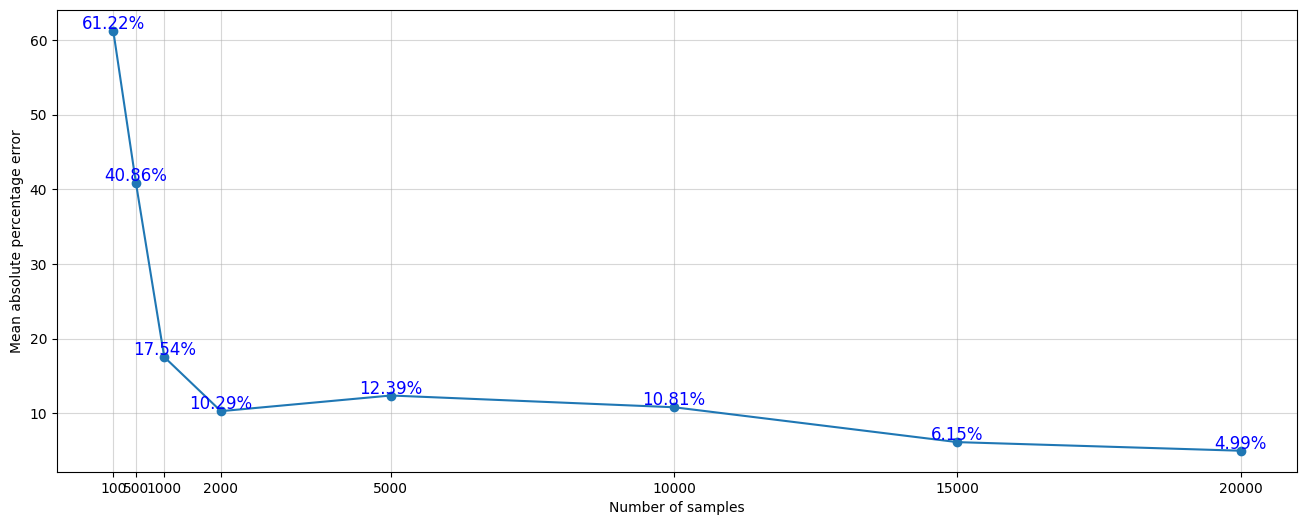

In [68]:
import matplotlib.pyplot as plt

samples = [100,500,1000,2000,5000,10000,15000,20000]
mapes = []

for m in samples:
    mc_shapley = monte_carlo_shapley(new_agents, v_monte_carlo, m)
    approx_shapley = [mc_shapley_values[agent] for agent in sorted(mc_shapley_values.keys(), key=int)]
    mapes.append(calculate_mape(classic_shapley, mc_shapley))

plt.figure(figsize=(16, 6))
plt.plot(samples, mapes, marker='o')
plt.xlabel('Number of samples')
plt.ylabel('Mean absolute percentage error')

# add the precise percentage error on the single point
for i, (x, y) in enumerate(zip(samples, mapes)):
    plt.text(x, y + 0.3, f'{y:.2f}%', fontsize=12, ha='center', color='blue')

xticks_labels = [f'{x}' for x in samples]
plt.xticks(ticks=samples, labels=xticks_labels)
plt.grid(alpha=0.5)

plt.show()

### **Core**

In [17]:
# Check if each player's outcome (that is, each shapley value) is positive
def is_positive(outcome):
    for i in outcome.values():
        if i < 0:
            return False
    return True


# Check if all the value (reward) is allocated in the outcome
def is_efficient(outcome, characteristic_function, players):
    grand_coalition = characteristic_function[frozenset(players)]
    sum = 0
    for i in outcome.values():
        sum += i
    # We use the function round() for a correct rounding
    # The function int() just cast the number into an integere by truncating the decimals
    return round(sum) == grand_coalition


# Check if an outcome for a given game is stable, that is no coalition wants to deviate from the outcome
def is_stable(outcome, characteristic_function):
    for c in characteristic_function.keys():
        sum = 0
        for i in c:
            sum += outcome[i]
        if sum < characteristic_function[c]:
            print("----- Stability check -----")
            print("Coalition for which the outcome is not stable: ", c)
            print("Total outcome of the non-stable coalition: ", sum, " < ", "v(coalition): ", characteristic_function[c])
            return False

    return True


# This function applies the definition of core to check whether an outcome is in the core of a game
def is_in_the_core(outcome, characteristic_function, players):
    positive = is_positive(outcome)
    efficient = is_efficient(outcome, characteristic_function, players)
    stable = is_stable(outcome, characteristic_function)

    print("--------------------------")
    print("Is the outcome positive? ", positive)
    print("--------------------------")
    print("Is the outcome efficient? ", efficient)
    print("--------------------------")
    print("Is the outcome stable? ", stable)
    print("--------------------------")
    return positive and efficient and stable

In [18]:
# Checking if the Shapley value is in the core of the game means checking:
#   - positivity
#   - efficiency
#   - stability

# According to the example, the shapley values should be {'4': 66.66666666666666, '3': 16.666666666666664, '2': 16.666666666666664, '1': 0.0}
# Hence, the outcome (Shapley values) should be:
# POSITIVE: since every player outcome is >= 0,
# EFFICIENT: since the sum of all the outcomes is equal to the characteristic_function value of the grand coalition
# NOT STABLE: since there are some coalitions C such that the sum of the shapley values of the players of C is < the value of the characteristic_function of C
# Example: coalition {'4', '2'}
print("\nIs in the core? ", is_in_the_core(shapley_values, v, agents))

----- Stability check -----
Coalition for which the outcome is not stable:  frozenset({'4', '3'})
Total outcome of the non-stable coalition:  83.34  <  v(coalition):  100
--------------------------
Is the outcome positive?  True
--------------------------
Is the outcome efficient?  True
--------------------------
Is the outcome stable?  False
--------------------------

Is in the core?  False


## **Task 2**

Assume that each agent i∈ N might freely decide whether to join the group in order to complete the task. In particular, each agent incurs a fixed cost of c_i to join the group and s/he is selfish interested, so that s/he would like that the revenue s/he gets by collaboration covers this expense (in the example, let c_1 = c_2 = 10$, c_3 = 20$, c_4 = 40$. Assume that the revenue is divided according to the Shapley value of the coalitional game induced by the agents that join the group (as in item 1). Then, check whether the resulting strategic setting, where each agent has two actions (joint, not join), admits a pure Nash equilibrium and computes one, if any.


In [19]:
from typing import FrozenSet

costs = {
    "1":10,
    "2":10,
    "3":20,
    "4":40
}

def compute_decisions(characterictic_function: dict, players_costs : dict, shapley_value: dict) -> dict:
  coalition_decisions = {}
  for coalition in characterictic_function:
    if characterictic_function[coalition] != 100:
      continue
    else:
      players_decisions = {}
      for player in coalition:
        player_cost_and_decision = {}
        if players_costs[player] > shapley_value[player]:
          player_cost_and_decision[shapley_value[player] - players_costs[player]] = "NO"
        else:
          player_cost_and_decision[shapley_value[player] - players_costs[player]] = "YES"
        players_decisions[player] = player_cost_and_decision
      coalition_decisions[coalition] = players_decisions

  return coalition_decisions

decisions = compute_decisions(v,players_costs=costs, shapley_value=shapley_values)

def print_decisions(decisions: dict):
    for coalition, players_decisions in decisions.items():
        print(f"Coalizione: {coalition}")
        for player, decision in players_decisions.items():
            for net_value, response in decision.items():
                print(f"  Giocatore {player}: Guadagno netto {net_value:.2f}, Decisione: {response}")
        print("-" * 30)  # Separatore tra coalizioni


def verify_nash_equilibrium(coalition: FrozenSet[str], characteristic_function: dict[FrozenSet[str], int], shapley_values: dict[str, int], agents_costs: dict[str, int]) -> bool:

    coalition_value = characteristic_function[coalition]
    # Check for players inside the coalition don't want to quit

    shapley_revenue = 0
    for player in coalition:
      if agents_costs[player] > shapley_values[player]:
        return False
      shapley_revenue += shapley_values[player]

    if coalition_value < shapley_revenue:
      return False



    # Check for players outside the coalition don't want to join

    all_players = frozenset(shapley_values.keys())
    outside_players = all_players - coalition

    # WITH THIS WE HAVE CHECKED ALL PLAYERS, SO ITS N
    for player in outside_players:
      if agents_costs[player] <= shapley_values[player]:

        new_coalition = coalition.union(frozenset([player]))
        new_coalition_value = characteristic_function[new_coalition]

        new_shapley_revenue = 0

        # THIS CAN BE N IN WORST CASE
        for player2 in new_coalition:
          new_shapley_revenue += shapley_values[player2]

        if new_coalition_value < new_shapley_revenue:
          continue
        else:
          return False

    # IN TOTAL IS N^2

    return True


def compute_nash_equilibrium_coalitions(characteristic_function: dict[FrozenSet[str], int], shapley_values: dict[str, int], agents_costs: dict[str, int]) -> list[FrozenSet[str]]:

    # 2^N POSSIBILE ITERATIONS (POWERSET SIZE)
    good_coalitions = []
    for coalition in characteristic_function.keys():
        if verify_nash_equilibrium(coalition, characteristic_function, shapley_values, agents_costs):
            good_coalitions.append(coalition)
    return good_coalitions

compute_nash_equilibrium_coalitions(characteristic_function=v, shapley_values=shapley_values, agents_costs=costs)

[frozenset({'2', '4'}), frozenset()]

## **Task 3**

Assume that all agents participate to the setting, but they might cheat on the cost c_i, and consider a setting where a mechanism has to identify a group of agents that is capable of completing the task with the minimum overall cost. Then, compute a payment scheme that provides incentives to truthfully report such costs.

In [20]:
"""
Setting: combinatorial auctions (VCG Auction)

Bidders: the agents
Items: the skills

Each agent (bidder) "i" values their set of skills "S_i" with the cost "c_i", thus we have:
    value_i(S_i) = c_i

Going with the given example we have the following set of bids:
    {
        '1': {['s1']: 10$},
        '2': {['s1', 's2']: 10$},
        '3': {['s1', 's2']: 20$},
        '4': {['s3']: 40$}
    }

We use the "compute_winner" function as the mechanism that identifies the group of agent capable of completing the task with the minimum cost

We use the "VCG_auction" function to determine the payment for each agent in the group
"""

"""
# To give personalized input w.r.t. task 1 and 2

bids = {
        '1': {frozenset(['s1']): 10},
        '2': {frozenset(['s1', 's2']): 10},
        '3': {frozenset(['s1', 's2']): 30},
        '4': {frozenset(['s3']): 40}
}
"""

declared_costs = {
    '1': 10,
    '2': 10,
    '3': 20,
    '4': 40
}

bids: dict[str, dict[frozenset, int]] = {}

for agent in agents:
  bids[agent] = {}
  bids[agent][frozenset(skills_map[agent])] = declared_costs[agent]

print(bids)

{'4': {frozenset({'s3'}): 40}, '3': {frozenset({'s1', 's2'}): 20}, '1': {frozenset({'s1'}): 10}, '2': {frozenset({'s1', 's2'}): 10}}


In [21]:
from itertools import combinations
import copy as cp

"""
This functions were used in the initial steps of this program, but are not optimized since need to
generate (and store) the whole powerset and then check manually the admissibility of each allocation.

For this reason this methods are not used, thus it's pointless to run this cell
"""



# A function to generate the powerset: it returns a list of 2^(n-1) frozen sets
# This funciton generates also the non admissible allocations
def powerset_no_empty_set(List):
    subs = [frozenset(j) for i in range(len(List)) for j in combinations(List, i+1)]
    # for item in subs:
    #   print(item)
    return subs

# A function to generate the powerset of only the admissible allocations
# This function generates all the solutions and then checks the admissibility
def powerset_only_admissible(List):
    subs = [frozenset(j) for i in range(len(List)) for j in combinations(List, i+1)]
    subs_copy = cp.deepcopy(subs)

    for item in subs:
      if not is_admissible(item):
        subs_copy.remove(item)
    return subs_copy

In [22]:
def from_dict_to_list_bids(bids):
    l = [(bidder, itemset, value) for bidder in bids for itemset,value in bids[bidder].items()]
    return l


def is_admissible(allocation) -> bool:
    '''
    This function returns True if the allocation is admissible and False otherwise.

    An allocation is admissible if and only if the following two conditions are satisfied:
        1) every item is allocated

    An allocation has form:
        [('a', {'I1', 'I2'}, 10), ...]
    Where:
        1) 'a' is a bidder
        2) {'I1', 'I2'} is an itemset
        3) 10 is the value of the itemset for the bidder
    '''
    bidders = [bidder for bidder, _, _ in allocation]

    # print(f"{bidders} => {v[frozenset(bidders)]}")
    return v[frozenset(bidders)] == 100


def next_solution(bitmap: list[bool], bids: list[tuple[str, frozenset, int]]) -> tuple[list[tuple[str, frozenset, int]], list[bool]]:
  ind = -1                  # position of the least significant zero bit
  for i in range(len(bitmap)-1, -1, -1):
    if not bitmap[i]:
      ind = i
      break

  current: list[bool] = bitmap[:ind]    # copies all bits from the most significant to the one in position ind-1
  current.append(True)      # updates the bits in position ind
  for i in range(ind+1, len(bitmap)):
    current.append(False)   # resets to 0 all the following bits

  ret: list[tuple[str, frozenset, int]] = []

  i = 0
  for bidder, itemset, value in bids:       # bids has one item for each agent, thus a 1-to-1 mapping to the bitmap
    if current[i]:
      ret.append((bidder, itemset, value))
    i += 1

  return ret, current


def has_next_solution(bitmap: list[bool]):
  for i in range(len(bitmap)-1, -1, -1):
    if not bitmap[i]:     # if there's a 0 in the bitmap then there exists a next solution
      return True
  return False            # if all the bits in the bitmap are 1, we reached the last solution


def generate_only_admissible(bids: list[tuple[str, frozenset, int]]) -> list[list[tuple[str, frozenset, int]]]:
  """
  This function implements backtracking to generate all the admissible allocations for a given set of preferences "bids".
  The input "bids" is a list of triples of the form:
    [(bidder, itemset, value), ...]
  The output is the list of only the admissible allocations generated from "bids".
  """
  ret: list[list[tuple[str, frozenset, int]]] = []

  # last_generated is an auxiliary bitmap to help generate all the solutions
  last_generated = [False for i in range(len(bids))]  # we exclude the empty set because is never admissible if |S| >= 1

  while has_next_solution(last_generated):
    solution, last_generated = next_solution(last_generated, bids)
    if is_admissible(solution):
      ret.append(solution)

  return ret

# print(generate_only_admissible(from_dict_to_list_bids(bids)))       # to test the backtracking algorithm

In [23]:
import sys
import copy as cp

"""
Not useful in this case because there can be an overlap for the same skill on two different agents

def pairwise_disjoint(sets) -> bool:
    '''
    This function checks wether the sets contained in a list are pairwise disjoint
    '''
    for i in range(len(sets)):
      for j in range(i+1, len(sets)):
        for item in sets[i]:
          if item in sets[j]:
            return False
    return True
"""

def compute_allocation_value(allocation) -> int:
    '''
    An allocation is a list of tuples with the following semantic: (bidder, itemset, value).
    This function computes the total value of an allocation.
    '''
    ret = 0
    for bidder, itemset, value in allocation:
      ret += value
    return ret


def compute_winner(bids):

    list_bids: list = from_dict_to_list_bids(bids)

    print(f"Total computation: 2^{len(list_bids)}")

    optimal_allocation: list = []
    optimal_value: int = sys.maxsize # maximum possible integer, since we have to minimize the cost

    # generate the powerset of bids
    # for each allocation in the powerset, check if it is admissible and pairwise disjoint
      # then compute allocation value, confront it with the optimal value and if it is greater update optimal_allocation and optimal_value
    for allocation in generate_only_admissible(list_bids):
      val = compute_allocation_value(allocation)

      if val < optimal_value:
        optimal_allocation = allocation
        optimal_value = val

    if optimal_value == sys.maxsize:
      # no solution was admissible, 2 scenarios:
      #   - bad input configuration
      #   - computing VCG payment of pivotal agent
      return [], -1

    return optimal_allocation, optimal_value


def VCG_auction(bids):

    optimal_allocation, tot = compute_winner(bids)
    if (tot == -1):
      print("Bad formed input: skill set is not entarely covered")
      sys.exit()

    ret: list[ tuple[str, frozenset, int] ] = []
    total_payment: int = 0

    for bidder, itemset, value in optimal_allocation:
      bids_copy = cp.deepcopy(bids)
      bids_copy.pop(bidder, None) # to find the winner if the current bidder didn't partecipate

      sum_values_without_current = compute_winner(bids_copy)[1]
      sum_values_other_bidders = tot - value

      payment = 0

      if sum_values_without_current == -1:
        # pivotal agent, we give him exactly the entrance cost
        payment = value
      else:
        payment = sum_values_without_current - sum_values_other_bidders

      ret.append((bidder, itemset, payment))
      total_payment += payment

    if total_payment > reward:
      print(f"Auction aborted: the total payment exceeds the reward.\nPayments: {ret}, Reward: {reward}")
      sys.exit()

    return ret

In [24]:
print(compute_winner(bids))

Total computation: 2^4
([('4', frozenset({'s3'}), 40), ('2', frozenset({'s1', 's2'}), 10)], 50)


In [25]:
print(VCG_auction(bids))

Total computation: 2^4
Total computation: 2^3
Total computation: 2^3
[('4', frozenset({'s3'}), 40), ('2', frozenset({'s1', 's2'}), 20)]
